### 05 - Inference yoga pose detection

In [4]:
import pandas as pd
import numpy as np
from ultralytics import YOLO
import pickle
from scipy import stats
import matplotlib.pyplot as plt
from PIL import Image

#### Stap 1. Video inladen

In [5]:
file = 'C:\\Users\\joost.vanstreels\\PycharmProjects\\YOLOv8\\runs\\DATASET HM\\INFERENCE\\Video Joost.mp4'
file

'C:\\Users\\joost.vanstreels\\PycharmProjects\\YOLOv8\\runs\\DATASET HM\\INFERENCE\\Video Joost.mp4'

#### Stap 2. Keypoints genereren met YOLO

In [6]:
# Keuze uit verschillende modellen
model = YOLO('yolov8m-pose.pt')
#model = YOLO('yolov8n-pose.pt')

In [7]:
results_inference = model.predict(file, imgsz=320, vid_stride = 3, save=True, conf=0.5)



WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/93) C:\Users\joost.vanstreels\PycharmProjects\YOLOv8\runs\DATASET HM\INFERENCE\Video Joost.mp4: 320x192 1 person, 407.4ms
video 1/1 (2/93) C:\Users\joost.vanstreels\PycharmProjects\YOLOv8\runs\DATASET HM\INFERENCE\Video Joost.mp4: 320x192 1 person, 278.8ms
video 1/1 (3/93) C:\Users\joost.vanstreels\PycharmProjects\YOLOv8\runs\DATASET HM\INFERENCE\Video Joost.mp4: 320x192 1 person, 293.5ms
video 1/1 (4/93) C:\Users\joost.vanstreels\PycharmPro

#### Stap 3. Data postprocessing


In [8]:
# Image source, 17x2 keypoints, 17 confidences per keypoint opslaan in array
analytics_data = np.empty([1, 53])
i = 0
for r in results_inference:
    # De has_visible check controleert of er een persoon gedetecteerd is
    if r.keypoints.has_visible == True:
        frame_number = np.array([[i]])
        confidence = np.array([r.__getitem__(0).boxes.conf])
        keypoints = np.array([r.__getitem__(0).keypoints.xyn.numpy().flatten()])
        confidences = np.array([r.__getitem__(0).keypoints.conf.numpy().flatten()])

        # Combineer informatie van elk plaatje in 1 x 55 array (rij)
        new_row = np.concatenate((frame_number, confidence, keypoints, confidences), axis=1)

        # Voeg de rij toe in een array
        analytics_data = np.vstack((analytics_data, new_row))
    i = i + 1

In [9]:
# Verwijder de eerste rij uit het array
analytics_data = np.delete(analytics_data, 0, 0)
analytics_data

array([[          0,     0.92917,     0.59034, ...,     0.55362,    0.037513,    0.041194],
       [          1,     0.92171,      0.5852, ...,     0.59799,    0.047189,    0.048297],
       [          2,     0.92113,     0.57532, ...,     0.68246,    0.081397,    0.067614],
       ...,
       [         90,     0.93849,     0.63692, ...,    0.080887,   0.0058479,    0.013871],
       [         91,      0.9314,     0.66842, ...,    0.070649,    0.006869,    0.012727],
       [         92,     0.92174,     0.68797, ...,    0.089535,   0.0069854,    0.014018]])

In [10]:
# Dataframe maken met alle gegevens uit het array
colnames = ['frame_number', 'confidence', 'x00', 'y00', 'x01', 'y01', 'x02', 'y02','x03', 'y03','x04', 'y04','x05', 'y05','x06', 'y06','x07', 'y07','x08', 'y08','x09', 'y09','x10', 'y10','x11', 'y11','x12', 'y12','x13', 'y13','x14', 'y14','x15', 'y15','x16', 'y16', 'v00', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09', 'v10', 'v11`', 'v12', 'v13', 'v14', 'v15', 'v16']

analytics_df = pd.DataFrame(data = analytics_data, columns=colnames)
analytics_df

,frame_number,confidence,x00,y00,x01,y01,x02,y02,x03,y03,...,v07,v08,v09,v10,v11`,v12,v13,v14,v15,v16
0,0.0,0.929168,0.590343,0.295845,0.628369,0.276667,0.548017,0.277860,0.681795,0.293656,...,0.970941,0.975927,0.949382,0.957524,0.985069,0.986894,0.516705,0.553622,0.037513,0.041194
1,1.0,0.921711,0.585197,0.301340,0.621655,0.282856,0.544268,0.283772,0.672506,0.299936,...,0.976817,0.976060,0.958008,0.958359,0.987891,0.988642,0.583572,0.597991,0.047189,0.048297
2,2.0,0.921133,0.575323,0.300937,0.610285,0.284646,0.537147,0.285457,0.657720,0.305309,...,0.984870,0.972900,0.970594,0.954544,0.991587,0.991187,0.714568,0.682456,0.081397,0.067614
3,3.0,0.927049,0.560225,0.308056,0.593118,0.292352,0.525301,0.292698,0.637997,0.311314,...,0.981169,0.980805,0.966421,0.966832,0.993058,0.993528,0.700725,0.711318,0.074535,0.075182
4,4.0,0.923456,0.542464,0.309309,0.575809,0.293819,0.507728,0.294076,0.621614,0.312670,...,0.983279,0.977696,0.968471,0.961641,0.994218,0.994416,0.775468,0.769001,0.112245,0.104275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,88.0,0.950495,0.666928,0.022737,0.738202,0.000000,0.594011,0.000000,0.821498,0.025504,...,0.314897,0.849416,0.156460,0.566126,0.493058,0.706708,0.025024,0.061527,0.006301,0.011393
89,89.0,0.946967,0.675780,0.015963,0.748245,0.000000,0.601108,0.000000,0.828330,0.023036,...,0.234091,0.865664,0.163491,0.554212,0.490140,0.752115,0.026827,0.078155,0.006119,0.012283
90,90.0,0.938488,0.636917,0.024068,0.713276,0.000000,0.567596,0.000000,0.814113,0.013539,...,0.151698,0.871910,0.078417,0.516982,0.438144,0.751112,0.022194,0.080887,0.005848,0.013871
91,91.0,0.931400,0.668424,0.025517,0.743148,0.000000,0.598928,0.000000,0.837776,0.014079,...,0.250892,0.838010,0.121655,0.510290,0.460376,0.706549,0.028139,0.070649,0.006869,0.012727


In [11]:
analytics_df = analytics_df.apply(pd.to_numeric, errors='coerce')

In [12]:
analytics_df['all fours'] = abs(analytics_df[['y09','y10']].max(axis=1) -
                                      analytics_df[['y15','y16']].max(axis=1))

analytics_df['ver dist hips'] = analytics_df[['y11','y12']].min(axis=1) - \
                                      analytics_df[['y00','y01','y02','y03','y04']].min(axis=1)

analytics_df['standing'] = analytics_df[['y15','y16']].max(axis=1) - \
                                      analytics_df[['y00','y01','y02','y03','y04']].min(axis=1)

analytics_df['hor_dist_ankles'] = abs(analytics_df['x15'] - analytics_df['x16'])

analytics_df['hor dist wrists'] = abs(analytics_df['x09']-analytics_df['x10'])

analytics_df['ver dist wrists'] = (analytics_df['y05'] - analytics_df['y09']) + \
                                        (analytics_df['y06'] - analytics_df['y10'])

analytics_df['ver dist ankles'] = abs(analytics_df['x15']-analytics_df['x16'])


#### Stap 4. logica

In [13]:
X_inference = analytics_df.iloc[:, 2:60]
X_inference

,x00,y00,x01,y01,x02,y02,x03,y03,x04,y04,...,v14,v15,v16,all fours,ver dist hips,standing,hor_dist_ankles,hor dist wrists,ver dist wrists,ver dist ankles
0,0.590343,0.295845,0.628369,0.276667,0.548017,0.277860,0.681795,0.293656,0.488785,0.297007,...,0.553622,0.037513,0.041194,0.481342,0.464253,0.723333,0.279123,0.357663,-0.190930,0.279123
1,0.585197,0.301340,0.621655,0.282856,0.544268,0.283772,0.672506,0.299936,0.486403,0.302698,...,0.597991,0.047189,0.048297,0.482741,0.452552,0.717144,0.279328,0.350862,-0.175348,0.279328
2,0.575323,0.300937,0.610285,0.284646,0.537147,0.285457,0.657720,0.305309,0.481391,0.306789,...,0.682456,0.081397,0.067614,0.479579,0.437566,0.715354,0.249222,0.331964,-0.181904,0.249222
3,0.560225,0.308056,0.593118,0.292352,0.525301,0.292698,0.637997,0.311314,0.473679,0.312144,...,0.711318,0.074535,0.075182,0.481196,0.434614,0.707648,0.245385,0.292376,-0.177935,0.245385
4,0.542464,0.309309,0.575809,0.293819,0.507728,0.294076,0.621614,0.312670,0.455931,0.312591,...,0.769001,0.112245,0.104275,0.480125,0.426288,0.706181,0.231998,0.272447,-0.191953,0.231998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,0.666928,0.022737,0.738202,0.000000,0.594011,0.000000,0.821498,0.025504,0.474028,0.019760,...,0.061527,0.006301,0.011393,0.039887,0.887909,0.960272,0.087682,0.958088,-1.306634,0.087682
89,0.675780,0.015963,0.748245,0.000000,0.601108,0.000000,0.828330,0.023036,0.476292,0.017155,...,0.078155,0.006119,0.012283,0.026384,0.857714,0.919662,0.298268,0.967087,-0.734353,0.298268
90,0.636917,0.024068,0.713276,0.000000,0.567596,0.000000,0.814113,0.013539,0.458237,0.011483,...,0.080887,0.005848,0.013871,0.041035,0.838155,0.927247,0.344448,0.937110,-1.106718,0.344448
91,0.668424,0.025517,0.743148,0.000000,0.598928,0.000000,0.837776,0.014079,0.481872,0.007040,...,0.070649,0.006869,0.012727,0.114963,0.849331,0.961982,0.342631,0.894430,-1.162730,0.342631


In [14]:
y_inference_pred = np.full((len(X_inference),1), 5)

for i in range(0, len(X_inference)):
    if X_inference['all fours'].loc[i] < 0.39:
        if X_inference['ver dist hips'].loc[i] <-0.15: y_inference_pred[i] = 0
        elif X_inference['ver dist hips'].loc[i] < 0.2: y_inference_pred[i] = 2
    elif X_inference['standing'].loc[i] > 0.5:
            if X_inference['hor_dist_ankles'].loc[i] > 0.25:
                if X_inference['hor dist wrists'].loc[i] > 0.3: y_inference_pred[i] = 4
                elif X_inference['ver dist wrists'].loc[i] > 0.1: y_inference_pred[i] = 1
            elif X_inference['ver dist ankles'].loc[i] > 0.1: y_inference_pred[i] = 3

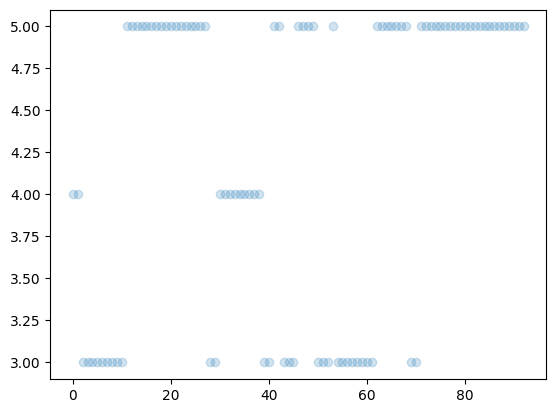

In [15]:
import matplotlib.pyplot as plt
plt.scatter(np.arange(0,len(y_inference_pred)), y_inference_pred, alpha=0.2)

#### Stap 5. Data postprocessing

#### Stap 6. Feedback logica

In [16]:
poses = {0:'downdog',
         1:'goddess',
         2:'plank',
         3:'tree',
         4:'warrior2',
         5:'overig'}

Pose found: plank


C:\Users\joost.vanstreels\AppData\Local\Temp\ipykernel_14752\3978736205.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  previous_pose = int(stats.mode(y_inference_pred[i:i+5])[0])


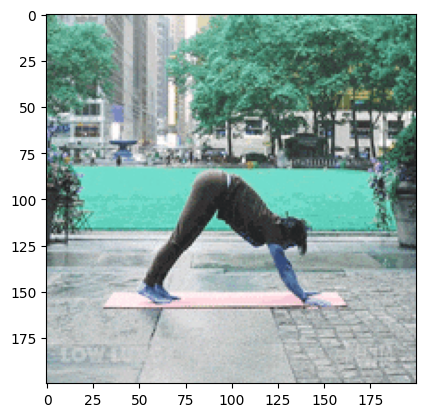

Pose found: downdog


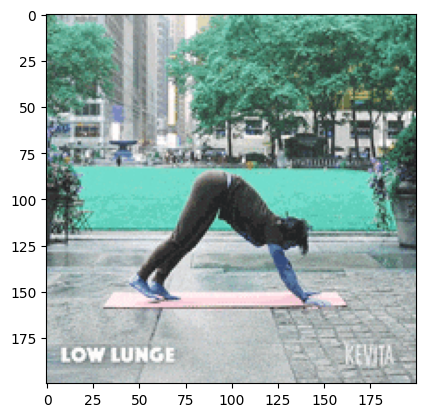

Pose found: plank


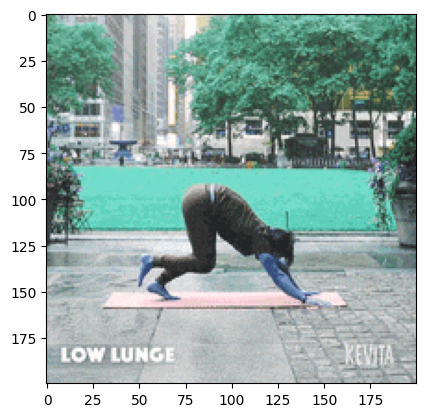

Pose found: overig


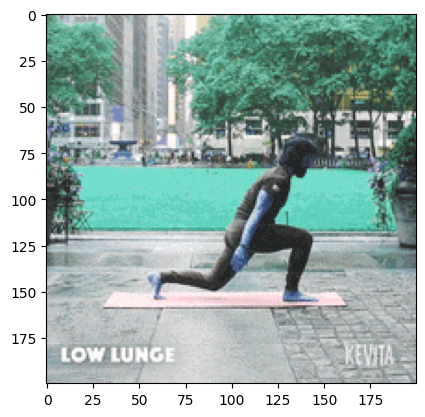

Pose found: plank


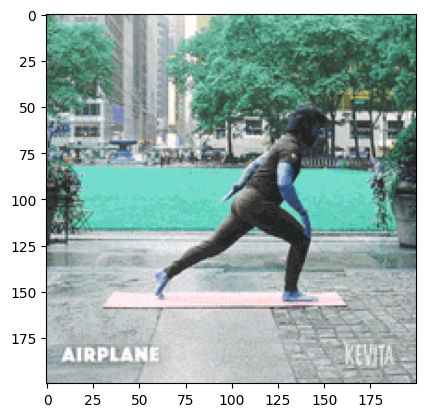

In [172]:
i = 0
previous_pose = 5
while i < len(y_inference_pred) - 5:
    if stats.mode(y_inference_pred[i:i+5])[1] > 3:
        if stats.mode(y_inference_pred[i:i+5])[0] != previous_pose:
            previous_pose = int(stats.mode(y_inference_pred[i:i+5])[0])
            print("Pose found: " + poses[previous_pose])
            image = Image.fromarray(results_inference[int(analytics_df['frame_number'].loc[i])].orig_img).convert('RGB')
            plt.imshow(image)
            plt.show()

        i = i + 5
    else: i = i + 1